<a href="https://colab.research.google.com/github/JALVITO/CE888/blob/master/Labs/Lab_3/Exercise_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

# Load Dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv', delimiter=";")
df_original = df.copy()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Pre-processing

In [3]:
# Use LabelEncoder to convert the label into numbers.
df[["y"]] = df[["y"]].apply(LabelEncoder().fit_transform)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [4]:
# Convert to One-Hot encoding
df = pd.get_dummies(df)
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [5]:
# Column "duration" must be deleted
df.drop(['duration'], axis=1, inplace=True)
df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [6]:
# Check if there are any missing values in the dataset. If there are, drop the rows.
print(f'NAN rows: {df[df.isna().any(axis=1)].shape[0]}')
df = df.dropna()

NAN rows: 0


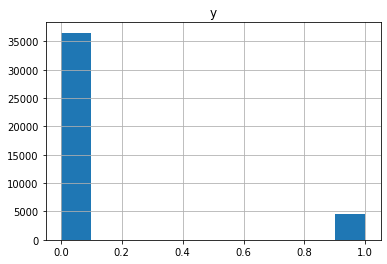

Class 0: 36548 (88.734583%)
Class 1: 4640 (11.265417%)


In [7]:
# Plot histogram of the label and calculate the imbalance in the dataset.
df.hist(column='y')
plt.show()

n = df.shape[0]
n_class0 = df[df["y"] == 0].shape[0]
n_class1 = df[df["y"] == 1].shape[0]

print(f'Class 0: {n_class0} ({n_class0/n:%})')
print(f'Class 1: {n_class1} ({n_class1/n:%})')

# Data modeling

In [8]:
# Split into stratified train and test sets
x = df.drop('y', axis=1).copy()
y = df[['y']].copy().values.ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50, stratify=y)

n_train = y_train.shape[0]
n_train_class0 = np.where(y_train == 0)[0].shape[0]
n_train_class1 = np.where(y_train == 1)[0].shape[0]

print('Training:')
print(f'Class 0: {n_train_class0} ({n_train_class0/n_train:%})')
print(f'Class 1: {n_train_class1} ({n_train_class1/n_train:%})')

n_test = y_test.shape[0]
n_test_class0 = np.where(y_test == 0)[0].shape[0]
n_test_class1 = np.where(y_test == 1)[0].shape[0]

print('\nTesting:')
print(f'Class 0: {n_test_class0} ({n_test_class0/n_test:%})')
print(f'Class 1: {n_test_class1} ({n_test_class1/n_test:%})')

Training:
Class 0: 29238 (88.734446%)
Class 1: 3712 (11.265554%)

Testing:
Class 0: 7310 (88.735130%)
Class 1: 928 (11.264870%)


In [9]:
# Train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=3)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1')
print("Forest Training F1: %.2f" % scores.mean())

Forest Training F1: 0.23


In [10]:
# Compare results to dummy classifier
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train, y_train)
print("Dummy Training F1: %.2f" % f1_score(y_train, dummy_clf.predict(x_train)))

Dummy Training F1: 0.11


In [11]:
# Search for better parameters
param_grid = {
    'n_estimators': [100, 200, 400],
    'criterion': ['gini','entropy'],
    'max_depth': [3,4,5],
}

search = GridSearchCV(RandomForestClassifier(), param_grid)
search.fit(x_train, y_train)

print("GridSearchCV F1 = %.2f" % f1_score(y_train, search.predict(x_train)))

GridSearchCV F1 = 0.28


In [12]:
# Get most important features
importances = search.best_estimator_.feature_importances_
features = list(x_train.columns.values)
indices = np.argsort(importances)[::-1]

print("Top 3 features:")

for f in range(3):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

Top 3 features:
1. nr.employed (0.221715)
2. euribor3m (0.153630)
3. emp.var.rate (0.109325)


In [13]:
# Report generalization error
print("Generalization F1 = %.2f" % f1_score(y_test, search.predict(x_test)))

Generalization F1 = 0.31


# Quiz

In [14]:
df_original.shape[0]

41188

In [15]:
num_cols = df_original.select_dtypes(include=np.number).columns.tolist()
len(num_cols)

10

In [16]:
clf = RandomForestClassifier(n_estimators=200, max_depth=8)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1')
print("Forest Training F1: %.2f" % scores.mean())

Forest Training F1: 0.30


In [17]:
clf = RandomForestClassifier(n_estimators=250, max_depth=6)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1')
print("Forest Training F1: %.2f" % scores.mean())

Forest Training F1: 0.28


In [18]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=60)
clf.fit(x_train, y_train)
print("Generalization F1 = %.2f" % f1_score(y_test, clf.predict(x_test)))

Generalization F1 = 0.34


In [19]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=60)
clf.fit(x_train, y_train)

# Get most important features
importances = clf.feature_importances_
features = list(x_train.columns.values)
indices = np.argsort(importances)[::-1]

print("Top 3 features:")

for f in range(3):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

Top 3 features:
1. nr.employed (0.146933)
2. euribor3m (0.142862)
3. pdays (0.093918)
